# Table of Contents
 <p><div class="lev1"><a href="#Task-1.-Compiling-Ebola-Data"><span class="toc-item-num">Task 1.&nbsp;&nbsp;</span>Compiling Ebola Data</a></div>
 <div class="lev1"><a href="#Task-2.-RNA-Sequences"><span class="toc-item-num">Task 2.&nbsp;&nbsp;</span>RNA Sequences</a></div>
 <div class="lev1"><a href="#Task-3.-Class-War-in-Titanic"><span class="toc-item-num">Task 3.&nbsp;&nbsp;</span>Class War in Titanic</a></div></p>

In [3]:
DATA_FOLDER = 'Data' # Use the data folder provided in Tutorial 02 - Intro to Pandas.

## Task 1. Compiling Ebola Data

The `DATA_FOLDER/ebola` folder contains summarized reports of Ebola cases from three countries (Guinea, Liberia and Sierra Leone) during the recent outbreak of the disease in West Africa. For each country, there are daily reports that contain various information about the outbreak in several cities in each country.

Use pandas to import these data files into a single `Dataframe`.
Using this `DataFrame`, calculate for *each country*, the *daily average per month* of *new cases* and *deaths*.
Make sure you handle all the different expressions for *new cases* and *deaths* that are used in the reports.

In [4]:
import pandas as pd
import glob as glob
import datetime as dt

#We only take care of confirmed deaths

def read_country(country):
    files = glob.glob(DATA_FOLDER + "/ebola/" + country + "/*.csv")
    df = pd.concat((pd.read_csv(file) for file in files))
    df['Country'] = country
    return df.fillna(0)

def read_countries():
    df = read_country("guinea_data")
    df = df.append(read_country("sl_data"))
    df = df.append(read_country("liberia_data"))
    return df


def normalize(df):
    df['Date'].fillna(df['date'], inplace=True)
    df['Month'] = df['Date'].map(getMonth)
    df['Day'] = df['Date'].map(getDay)
    df['Description'].fillna(df['Variable'], inplace=True)
    df['Description'].fillna(df['variable'], inplace=True)
    df['Totals'].fillna(df['National'], inplace=True)
    del df['Date']
    del df['date']
    del df['Variable']
    del df['variable']
    del df['National']
    
def getMonth(date):
    if ('/' in date):
        try :
            d = dt.datetime.strptime(date, "%m/%d/%Y")
        except ValueError:
            d = dt.datetime.strptime(date, "%m/%d/%y")
    else: d = dt.datetime.strptime(date, "%Y-%m-%d")
    return d.month

def getDay(date):
    if ('/' in date):
        try :
            d = dt.datetime.strptime(date, "%m/%d/%Y")
        except ValueError:
            d = dt.datetime.strptime(date, "%m/%d/%y")
    else: d = dt.datetime.strptime(date, "%Y-%m-%d")
    return d.day


def compute_means(tots):
    tots = tots.astype(float)
    return tots.groupby(['Month'])['Totals'].mean()

def guinea_death_means(guin):
    print("Average daily deaths per month")
    guinTots = guin[(guin['Description'] == "New deaths registered today")
                   | (guin['Description'] == "New deaths registered")][['Totals', 'Month']]
    return compute_means(guinTots)
    
def guinea_nc_means(guin):    
    print("Average daily new cases per month")
    guinTots = guin[guin['Description'] == "Total new cases registered so far"][['Totals', 'Month']]
    return compute_means(guinTots)

def liberia_death_means(lib):
    print("Average daily deaths per month")
    lib = lib[lib['Month'] < 12]
    libTots = lib[lib['Description'] == "Newly reported deaths"][['Totals', 'Month']]
    return compute_means(libTots)

def liberia_nc_means(lib):   
    print("Average daily new cases per month")
    lib = lib[lib['Month'] < 12]
    libTots = lib[(lib['Description'] == "New Case/s (Suspected)")
                 | (lib['Description'] == "New Case/s (Probable)")
                 | (lib['Description'] == "New case/s (confirmed)")][['Totals', 'Month']]
    return compute_means(libTots) * 3

def deaths_on(month, day):
    deaths = month[month['Day'] == day]
    return deaths[deaths['Description'] == "death_confirmed"][['Totals']].iloc[0].astype(float)

def sl_month_deaths(month):
    last_day = month['Day'].max()
    first_day = month['Day'].min()
    tot = deaths_on(month, last_day) - deaths_on(month, first_day)
    return tot / (last_day - first_day + 1)
    
def sl_death_means(sl):
    print("Average daily deaths per month")
    sl = sl[sl['Month'] < 12.0]
    return sl.groupby(['Month']).apply(sl_month_deaths)

def sl_nc_means(sl):   
    print("Average daily new cases per month")
    slTots = sl[(sl['Description'] == "new_suspected")
                 | (sl['Description'] == "new_probable")
                 | (sl['Description'] == "new_confirmed")][['Totals', 'Month']]
    return compute_means(slTots) * 3


df = read_countries()

# check that the sum of the columns is correct
# What if the variables are different?
normalize(df)
print("1. Guinea")
guin = df[df['Country'] == "guinea_data"]
print(guinea_death_means(guin), "\n")
print(guinea_nc_means(guin), "\n")
print("2. Liberia")
lib = df[df['Country'] == "liberia_data"]
print(liberia_death_means(lib), "\n")
print(liberia_nc_means(lib), "\n")
print("3. Sierra Leone")
sl = df[df['Country'] == "sl_data"]
print(sl_death_means(sl), "\n")
print(sl_nc_means(sl))


1. Guinea
Average daily deaths per month
Month
8.0      3.4000
9.0      3.5625
10.0    15.0000
Name: Totals, dtype: float64 

Average daily new cases per month
Month
8.0     25.800
9.0     19.625
10.0    34.000
Name: Totals, dtype: float64 

2. Liberia
Average daily deaths per month
Month
6.0      2.000000
7.0      4.272727
8.0     23.222222
9.0     36.041667
10.0    28.040000
11.0    13.466667
Name: Totals, dtype: float64 

Average daily new cases per month
Month
6.0      5.714286
7.0      8.545455
8.0     37.222222
9.0     63.833333
10.0    45.560000
11.0    26.466667
Name: Totals, dtype: float64 

3. Sierra Leone
Average daily deaths per month
11        Totals
Month           
8       6.150000
9       5.133333
10     17.354839
11     14.448276 

Average daily new cases per month
Month
8.0     25.150000
9.0     40.689655
10.0    70.928571
11.0    75.238095
12.0    41.000000
Name: Totals, dtype: float64


## Task 2. RNA Sequences

In the `DATA_FOLDER/microbiome` subdirectory, there are 9 spreadsheets of microbiome data that was acquired from high-throughput RNA sequencing procedures, along with a 10<sup>th</sup> file that describes the content of each. 

Use pandas to import the first 9 spreadsheets into a single `DataFrame`.
Then, add the metadata information from the 10<sup>th</sup> spreadsheet as columns in the combined `DataFrame`.
Make sure that the final `DataFrame` has a unique index and all the `NaN` values have been replaced by the tag `unknown`.

In [14]:
import os
import glob as glob
import pandas as pd

def read_files():  
    files = glob.glob(DATA_FOLDER + "/microbiome/MID*.xls")
    df = pd.DataFrame()
    meta = pd.read_excel(DATA_FOLDER + "/microbiome/metadata.xls")
    i = 0
    for file in files:
        new = pd.read_excel(file, header=None)
        new['BARCODE'] = meta.iloc[i]['BARCODE']
        new['GROUP'] = meta.iloc[i]['GROUP']
        new['SAMPLE'] = meta.iloc[i]['SAMPLE']
        df = df.append(new)
        i += 1
    df['Index'] = list(range(df.shape[0]))
    columns = df.columns.tolist()
    columns = columns[-1:] + columns[:-1]
    df = df[columns]
    return df.fillna("unknown")


read_files()

       

,Index,0,1,BARCODE,GROUP,SAMPLE
0,0,"Archaea ""Crenarchaeota"" Thermoprotei Desulfuro...",7,MID1,EXTRACTION CONTROL,unknown
1,1,"Archaea ""Crenarchaeota"" Thermoprotei Desulfuro...",2,MID1,EXTRACTION CONTROL,unknown
2,2,"Archaea ""Crenarchaeota"" Thermoprotei Sulfoloba...",3,MID1,EXTRACTION CONTROL,unknown
3,3,"Archaea ""Crenarchaeota"" Thermoprotei Thermopro...",3,MID1,EXTRACTION CONTROL,unknown
4,4,"Archaea ""Euryarchaeota"" ""Methanomicrobia"" Meth...",7,MID1,EXTRACTION CONTROL,unknown
5,5,"Archaea ""Euryarchaeota"" ""Methanomicrobia"" Meth...",1,MID1,EXTRACTION CONTROL,unknown
6,6,"Archaea ""Euryarchaeota"" ""Methanomicrobia"" Meth...",1,MID1,EXTRACTION CONTROL,unknown
7,7,"Archaea ""Euryarchaeota"" Archaeoglobi Archaeogl...",1,MID1,EXTRACTION CONTROL,unknown
8,8,"Archaea ""Euryarchaeota"" Archaeoglobi Archaeogl...",1,MID1,EXTRACTION CONTROL,unknown
9,9,"Archaea ""Euryarchaeota"" Halobacteria Halobacte...",1,MID1,EXTRACTION CONTROL,unknown


## Task 3. Class War in Titanic

Use pandas to import the data file `Data/titanic.xls`. It contains data on all the passengers that travelled on the Titanic.

In [46]:
from IPython.core.display import HTML
HTML(filename=DATA_FOLDER+'/titanic.html')

Name,Labels,Units,Levels,Storage,NAs
pclass,,,3,integer,0
survived,Survived,,,double,0
name,Name,,,character,0
sex,,,2,integer,0
age,Age,Year,,double,263
sibsp,Number of Siblings/Spouses Aboard,,,double,0
parch,Number of Parents/Children Aboard,,,double,0
ticket,Ticket Number,,,character,0
fare,Passenger Fare,British Pound (\243),,double,1
cabin,,,187,integer,0


For each of the following questions state clearly your assumptions and discuss your findings:
1. Describe the *type* and the *value range* of each attribute. Indicate and transform the attributes that can be `Categorical`. 
2. Plot histograms for the *travel class*, *embarkation port*, *sex* and *age* attributes. For the latter one, use *discrete decade intervals*. 
3. Calculate the proportion of passengers by *cabin floor*. Present your results in a *pie chart*.
4. For each *travel class*, calculate the proportion of the passengers that survived. Present your results in *pie charts*.
5. Calculate the proportion of the passengers that survived by *travel class* and *sex*. Present your results in *a single histogram*.
6. Create 2 equally populated *age categories* and calculate survival proportions by *age category*, *travel class* and *sex*. Present your results in a `DataFrame` with unique index.

In [176]:
# Question 1
import pandas as pd

df = pd.read_excel(DATA_FOLDER + "/titanic.xls")
print("Types:")
print(df.columns.to_series().groupby(df.dtypes).groups, "\n")
print("Value Ranges:")
lowest = df.describe().loc['min']
highest = df.describe().loc['max']
for i in range(lowest.shape[0]):
    print(lowest.index[i], "\t", lowest[i], "-", highest[i])

print("Categorical data: pclass, survived, sex, cabin, embarked, boat")
df['pclass'] = pd.Categorical(df['pclass'])
df['survived'] = pd.Categorical(df['survived'])
df['sex'] = pd.Categorical(df['sex'])
df['cabin'] = pd.Categorical(df['cabin'].fillna("Unknown"))
df['embarked'] = pd.Categorical(df['embarked'])
df['boat'] = pd.Categorical(df['boat'])

Types:
{dtype('int64'): Index(['pclass', 'survived', 'sibsp', 'parch'], dtype='object'), dtype('float64'): Index(['age', 'fare', 'body'], dtype='object'), dtype('O'): Index(['name', 'sex', 'ticket', 'cabin', 'embarked', 'boat', 'home.dest'], dtype='object')} 

Value Ranges:
pclass 	 1.0 - 3.0
survived 	 0.0 - 1.0
age 	 0.1667 - 80.0
sibsp 	 0.0 - 8.0
parch 	 0.0 - 9.0
fare 	 0.0 - 512.3292
body 	 1.0 - 328.0
Categorical data: pclass, survived, sex, cabin, embarked, boat


Populating the interactive namespace from numpy and matplotlib


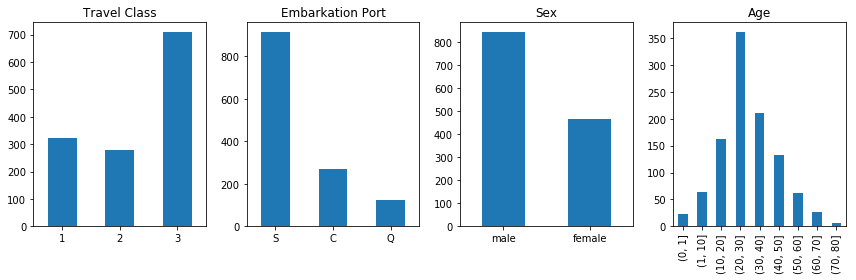

In [203]:
# Question 2
import matplotlib.pyplot as plt
%pylab inline

fig, axs = plt.subplots(1,4, figsize=(12,4))

df.pclass.value_counts(sort=False).plot(ax=axs[0], kind='bar', rot=0, title="Travel Class")
df.embarked.value_counts().plot(ax=axs[1], kind='bar', rot=0, title="Embarkation Port")
df.sex.value_counts().plot(ax=axs[2], kind='bar', title="Sex", rot=0)
pd.cut(df.age, [0,1,10,20,30,40,50,60,70,80]).value_counts(sort=False).plot(ax=axs[3], kind='bar', title="Age")
plt.tight_layout()

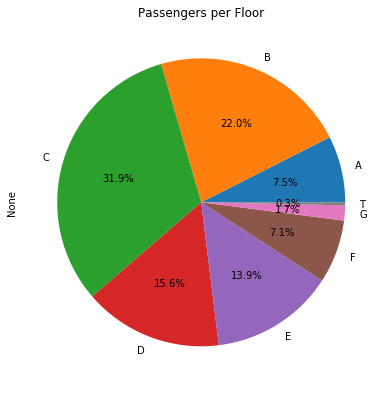

In [204]:
# Question 3
# The starting letter of the cabin is the floor. 
# Cabins with more than one letter such as "F G63" 
# are considered correct (Source: "https://www.encyclopedia-titanica.org/").

df['floor'] = df['cabin'].map(lambda x: x[0])
fig = plt.figure(figsize=(10,5))
ax = fig.add_axes((0,0,.5,1))
p_per_floor = df.groupby(['floor']).size().drop("U")
p_per_floor.plot(kind='pie', ax=ax, title="Passengers per Floor",  autopct='%1.1f%%')
